In [9]:
# Import Library
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.sparse import hstack
from datetime import datetime
import matplotlib

# Download NLTK resources
nltk.download('stopwords')

# Print library versions
import sklearn # Import sklearn to get version

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
try:
    print(f"re version: {re.__version__}")
except AttributeError:
    print("re version: N/A")
print(f"nltk version: {nltk.__version__}")
print(f"scikit-learn version: {sklearn.__version__}") # TfidfVectorizer, train_test_split, RandomForestClassifier, CalibratedClassifierCV, classification_report, roc_auc_score, precision_recall_curve, f1_score are from sklearn
print(f"xgboost version: {xgb.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"joblib version: {joblib.__version__}")

pandas version: 2.2.2
numpy version: 2.0.2
re version: 2.2.1
nltk version: 3.9.1
scikit-learn version: 1.6.1
xgboost version: 3.1.0
matplotlib version: 3.10.0
seaborn version: 0.13.2
joblib version: 1.5.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# ======================
# 1. LOAD & PREPROCESS DATA
# ======================

# Load dataset
df = pd.read_csv('/content/phishing_email.csv')

# Cek struktur dataset
print("Dataset shape:", df.shape)
print("Dataset columns:", df.columns.tolist())

# Handle missing values
# Cari nama kolom target yang benar
target_col = None
for col in df.columns:
    if col.lower() in ['label', 'target', 'class', 'category']:
        target_col = col
        break

if target_col is None:
    # Jika tidak ditemukan, asumsikan kolom terakhir adalah target
    target_col = df.columns[-1]
    print(f"Warning: Target column not found, using last column: {target_col}")

print(f"Using target column: {target_col}")

# Handle missing values
df = df.dropna(subset=[target_col])
df[target_col] = df[target_col].astype(int)

Dataset shape: (7436, 2)
Dataset columns: ['text_combined', 'label']
Using target column: label


In [11]:
# ======================
# 2. ENHANCED PREPROCESSING
# ======================

def enhanced_preprocess_combined_text(text):
    # Ekstraksi komponen penting
    date_pattern = r'\w{3}\s\w{3}\s\d{1,2}\s\d{4}'
    sender_pattern = r'[\w\.-]+@[\w\.-]+\.\w+'

    # Ekstraksi tanggal
    date_match = re.search(date_pattern, text)
    extracted_date = date_match.group(0) if date_match else ""

    # Ekstraksi pengirim
    sender_match = re.search(sender_pattern, text)
    extracted_sender = sender_match.group(0) if sender_match else ""

    # Bersihkan teks dengan penanganan khusus untuk phishing
    clean_text = re.sub(date_pattern, '', text)
    clean_text = re.sub(sender_pattern, '', clean_text)

    # Normalisasi karakter evasi
    clean_text = clean_text.replace('â€', "'")
    clean_text = clean_text.replace('â€œ', '"')
    clean_text = clean_text.replace('â€˜', "'")

    # Hapus pola attachment
    clean_text = re.sub(r'see attached file', '', clean_text, flags=re.IGNORECASE)

    # Hapus karakter khusus tapi pertahankan tanda baca penting
    clean_text = re.sub(r'[^\w\s\.\!\?]', '', clean_text)

    # Lowercase
    clean_text = clean_text.lower()

    # Hapus stopwords
    stop_words = set(stopwords.words('english'))
    clean_text = ' '.join([word for word in clean_text.split() if word not in stop_words])

    return clean_text, extracted_date, extracted_sender

# Terapkan preprocessing
df[['cleaned_text', 'extracted_date', 'extracted_sender']] = df['text_combined'].apply(
    lambda x: pd.Series(enhanced_preprocess_combined_text(x))
)


In [12]:
# ======================
# 3. COMPREHENSIVE PHISHING FEATURE EXTRACTION
# ======================

def extract_phishing_features(text):
    features = {}

    # 1. Suspicious Keywords (diperluas)
    phishing_keywords = [
        'urgent', 'immediate', 'action required', 'verify your account',
        'suspended', 'limited time', 'click here', 'update now',
        'confirm', 'security alert', 'unusual sign-in', 'locked account',
        'billing issue', 'payment failed', 'account locked', 'verify identity',
        'secure your account', 'unauthorized access', 'expiring today',
        'act now', 'limited offer', 'exclusive deal', 'confirm immediately'
    ]
    features['suspicious_keyword_count'] = sum(1 for keyword in phishing_keywords if keyword in text.lower())

    # 2. Realistic Suspicious Domains
    legitimate_short_domains = ['bit.ly', 't.co', 'goo.gl', 'ow.ly', 'buff.ly', 'mcaf.ee']
    suspicious_short_domains = [
        'tinyurl.com', 'short.url', 'tiny.cc', 'is.gd', 'adf.ly',
        'vzturl.com', 'cli.re', 'q.gs', 'u.to', 'yourl.io', 'po.st'
    ]

    features['has_legitimate_short_domain'] = 1 if any(domain in text.lower() for domain in legitimate_short_domains) else 0
    features['has_suspicious_short_domain'] = 1 if any(domain in text.lower() for domain in suspicious_short_domains) else 0

    # Deteksi typosquatting
    legitimate_domains = ['paypal.com', 'amazon.com', 'microsoft.com', 'apple.com', 'google.com']
    features['has_typosquatting'] = 0

    for domain in legitimate_domains:
        if domain in text.lower():
            typo_variations = [
                domain.replace('.com', '.co'),
                domain.replace('.com', '.org'),
                domain.replace('a', '4'), domain.replace('i', '1'),
                domain.replace('o', '0'), domain.replace('l', '1'),
                domain.replace('m', 'rn'), domain.replace('n', 'rn')
            ]
            if any(typo in text.lower() for typo in typo_variations):
                features['has_typosquatting'] = 1
                break

    # Deteksi IP address sebagai URL
    ip_pattern = r'https?://\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
    features['has_ip_url'] = 1 if re.search(ip_pattern, text) else 0

    # 3. Advanced Capital Word Analysis
    words = text.split()
    if words:
        capital_words = [word for word in words if word.isupper() and len(word) > 1]
        features['capital_word_ratio'] = len(capital_words) / len(words)

        sentences = re.split(r'[.!?]+', text)
        all_caps_sentences = sum(1 for sentence in sentences if sentence.strip() and sentence.strip().isupper())
        features['all_caps_sentences_ratio'] = all_caps_sentences / max(len(sentences), 1)

        # Deteksi kapital tidak wajar
        brands = ['paypal', 'amazon', 'microsoft', 'apple', 'google', 'facebook']
        acronyms = ['ID', 'URL', 'HTML', 'PDF', 'CEO', 'CFO']
        unusual_capitals = 0

        for i, word in enumerate(words):
            if word.isupper() and len(word) > 1:
                if i == 0 or words[i-1].endswith(('.', '!', '?')):
                    continue
                if word.lower() in brands or word in acronyms:
                    continue
                unusual_capitals += 1

        features['unusual_capital_ratio'] = unusual_capitals / len(words)
    else:
        features['capital_word_ratio'] = 0
        features['all_caps_sentences_ratio'] = 0
        features['unusual_capital_ratio'] = 0

    # 4. Advanced Exclamation Analysis
    exclamation_count = text.count('!')
    features['exclamation_count'] = exclamation_count
    features['exclamation_ratio'] = exclamation_count / max(len(text), 1)
    features['excessive_exclamation'] = 1 if exclamation_count > 5 else 0

    consecutive_exclamation = len(re.findall(r'!{3,}', text))
    features['consecutive_exclamation'] = consecutive_exclamation

    exclamation_positions = [i for i, char in enumerate(text) if char == '!']
    if exclamation_positions:
        mid_sentence_exclamations = 0
        for pos in exclamation_positions:
            if pos + 1 < len(text) and text[pos+1] not in ['.', ' ', '\n']:
                mid_sentence_exclamations += 1
        features['mid_sentence_exclamation_ratio'] = mid_sentence_exclamations / len(exclamation_positions)
    else:
        features['mid_sentence_exclamation_ratio'] = 0

    # 5. Urgency & Time Pressure
    urgency_words = ['urgent', 'immediately', 'asap', 'hurry', 'fast', 'quick', 'now', 'today', 'soon']
    features['urgency_word_count'] = sum(1 for word in urgency_words if word in text.lower())

    time_limit_keywords = ['24 hours', '48 hours', 'by tomorrow', 'today only', 'expires today']
    features['has_time_limit'] = 1 if any(keyword in text.lower() for keyword in time_limit_keywords) else 0

    # 6. Personal Information Request
    personal_info_keywords = [
        'ssn', 'social security', 'credit card', 'bank account',
        'password', 'pin', 'cvv', 'account number', 'card number',
        'expiration date', 'security code', 'routing number'
    ]
    features['personal_info_request'] = 1 if any(keyword in text.lower() for keyword in personal_info_keywords) else 0

    # 7. Threatening Language
    threat_keywords = ['suspend', 'terminate', 'close', 'deactivate', 'block', 'restrict', 'penalty', 'fee', 'fine']
    features['has_threat'] = 1 if any(keyword in text.lower() for keyword in threat_keywords) else 0

    # 8. Generic & Personalization Analysis
    generic_greetings = ['dear customer', 'dear user', 'dear sir/madam', 'valued customer', 'account holder']
    features['has_generic_greeting'] = 1 if any(greeting in text.lower() for greeting in generic_greetings) else 0

    personalization_placeholders = ['[name]', '[email]', '[customer]', '[user]']
    features['has_personalization_placeholder'] = 1 if any(ph in text.lower() for ph in personalization_placeholders) else 0

    # 9. Brand Mentions Analysis
    brands = ['paypal', 'amazon', 'microsoft', 'apple', 'google', 'facebook', 'instagram']
    brand_mentions = [brand for brand in brands if brand in text.lower()]
    features['brand_mention_count'] = len(brand_mentions)

    features['inconsistent_brand_mention'] = 0
    if brand_mentions:
        for brand in brand_mentions:
            suspicious_variations = [
                brand + 'support', brand + 'security', brand + 'team',
                brand + 'update', brand + 'alert', brand + 'notice'
            ]
            if any(variation in text.lower() for variation in suspicious_variations):
                features['inconsistent_brand_mention'] = 1
                break

    # 10. Spelling Errors
    common_misspellings = {
        'paypaI': 'paypal', 'appIe': 'apple', 'microsft': 'microsoft',
        'amaz0n': 'amazon', 'g00gle': 'google', 'faceb00k': 'facebook',
        'verifye': 'verify', 'securty': 'security', 'acount': 'account'
    }
    misspelling_count = sum(1 for misspelling in common_misspellings if misspelling in text.lower())
    features['spelling_errors_count'] = misspelling_count

    # 11. HTML & Technical Content
    html_tags = ['<html', '<div', '<table', '<form', '<script', '<iframe']
    features['has_html_content'] = 1 if any(tag in text.lower() for tag in html_tags) else 0

    features['has_form_submission'] = 1 if '<form' in text.lower() and 'action=' in text.lower() else 0
    features['has_javascript'] = 1 if 'javascript:' in text.lower() or '<script' in text.lower() else 0
    features['has_tracking_pixel'] = 1 if any(pixel in text.lower() for pixel in [
        'tracking pixel', 'open tracking', 'read receipt'
    ]) else 0
    features['has_unsubscribe_link'] = 1 if 'unsubscribe' in text.lower() else 0

    # 12. Link Analysis
    url_pattern = r'https?://[^\s]+'
    urls = re.findall(url_pattern, text)
    features['url_count'] = len(urls)

    misleading_anchors = ['click here', 'verify now', 'update account', 'sign in']
    features['has_misleading_link'] = 0

    for anchor in misleading_anchors:
        if anchor in text.lower():
            anchor_pos = text.lower().find(anchor)
            text_after_anchor = text[anchor_pos + len(anchor):anchor_pos + len(anchor) + 100]
            if re.search(url_pattern, text_after_anchor):
                features['has_misleading_link'] = 1
                break

    # 13. Behavioral Analysis
    features['multiple_redirects'] = 1 if len(urls) > 3 else 0
    features['shortened_url_only'] = 1 if (
        bool(re.search(r'\b(bit\.ly|t\.co|goo\.gl)\b', text)) and len(urls) == 1
    ) else 0
    features['image_only_text'] = 1 if (
        len(re.findall(r'\.(jpg|jpeg|png|gif)', text.lower())) > 0 and len(text.split()) < 20
    ) else 0

    # 14. Social Engineering Analysis
    features['authority_impersonation'] = 1 if any(impersonation in text.lower() for impersonation in [
        'fbi', 'cia', 'irs', 'police', 'government', 'bank', 'court'
    ]) else 0

    features['scarcity_tactic'] = 1 if any(scarcity in text.lower() for scarcity in [
        'only 2 left', 'last chance', 'almost gone', 'running out'
    ]) else 0

    features['social_proof'] = 1 if any(proof in text.lower() for proof in [
        'trusted by millions', 'used by fortune 500', 'recommended by experts'
    ]) else 0

    # 15. Psychological Triggers
    fear_words = ['hack', 'breach', 'compromised', 'stolen', 'fraud', 'suspended']
    features['fear_intensity'] = sum(1 for fear in fear_words if fear in text.lower())

    greed_words = ['free', 'win', 'prize', 'reward', 'discount', 'bonus']
    features['greed_trigger'] = sum(1 for greed in greed_words if greed in text.lower())

    curiosity_words = ['see what happened', 'you won\'t believe', 'shocking discovery']
    features['curiosity_trigger'] = sum(1 for curiosity in curiosity_words if curiosity in text.lower())

    # 16. Action Requests
    action_keywords = ['click', 'verify', 'update', 'confirm', 'sign in', 'log in', 'download']
    features['action_request_count'] = sum(1 for keyword in action_keywords if keyword in text.lower())

    # 17. Security Claims
    security_claims = ['secure', 'encrypted', 'protected', 'safe', 'trusted']
    features['security_claim_count'] = sum(1 for claim in security_claims if claim in text.lower())

    # 18. Attachment Analysis
    suspicious_extensions = ['.exe', '.zip', '.scr', '.bat', '.js', '.docm']
    features['has_suspicious_attachment'] = 1 if any(ext in text.lower() for ext in suspicious_extensions) else 0

    # 19. Contact Information
    suspicious_contact = [
        'call now', 'contact immediately', 'urgent call', 'phone verification',
        'verify by phone', 'confirm by call'
    ]
    features['has_suspicious_contact'] = 1 if any(contact in text.lower() for contact in suspicious_contact) else 0

    # 20. Contextual Analysis
    features['mentions_recent_events'] = 1 if any(event in text.lower() for event in [
        'covid', 'pandemic', 'election', 'holiday', 'black friday'
    ]) else 0

    features['seasonal_reference'] = 1 if any(season in text.lower() for season in [
        'christmas', 'thanksgiving', 'new year', 'summer', 'winter'
    ]) else 0

    # 21. Sender Analysis
    features['sender_content_mismatch'] = 0
    if 'paypal' in text.lower() and 'paypal' not in text.lower():
        features['sender_content_mismatch'] = 1

    return features

# Terapkan ekstraksi fitur phishing
phishing_features = df['text_combined'].apply(lambda x: pd.Series(extract_phishing_features(x)))
df = pd.concat([df, phishing_features], axis=1)

In [13]:
# ======================
# 4. URL & BRAND FEATURE EXTRACTION
# ======================

def extract_url_features(text):
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(url_pattern, text)

    features = {}
    features['url_count'] = len(urls)

    if urls:
        features['has_url_masking'] = 1 if any('bit.ly' in url or 'tinyurl' in url for url in urls) else 0
        features['has_homograph'] = 1 if any(
            re.search(r'[āàáâãäåæçćčđēėęěğįıñňöőŕřśšşťțůűųźžż]', url)
            for url in urls
        ) else 0
    else:
        features['has_url_masking'] = 0
        features['has_homograph'] = 0

    return features

def extract_brand_features(text):
    brands = ['paypal', 'amazon', 'microsoft', 'apple', 'google', 'facebook', 'instagram']
    features = {}

    for brand in brands:
        features[f'has_{brand}'] = 1 if brand in text.lower() else 0

    brand_spoofing = [
        'paypaI', 'arnazon', 'microsft', 'appIe', 'goggle',
        'faceboook', 'instagrarn'
    ]
    features['has_brand_spoofing'] = 1 if any(spoof in text.lower() for spoof in brand_spoofing) else 0

    return features

# Terapkan ekstraksi fitur URL dan brand
url_features = df['text_combined'].apply(lambda x: pd.Series(extract_url_features(x)))
brand_features = df['text_combined'].apply(lambda x: pd.Series(extract_brand_features(x)))
df = pd.concat([df, url_features, brand_features], axis=1)

In [14]:
# ======================
# 5. ENHANCED METADATA FEATURE EXTRACTION
# ======================

# 1. Fitur tanggal (dengan penanganan error yang lebih baik)
try:
    df['is_weekend'] = pd.to_datetime(df['extracted_date'], format='%a %b %d %Y', errors='coerce').dt.dayofweek >= 5
    df['hour_sent'] = pd.to_datetime(df['extracted_date'], format='%a %b %d %Y', errors='coerce').dt.hour
except:
    # Fallback jika format tanggal tidak sesuai
    df['is_weekend'] = 0
    df['hour_sent'] = 12

# 2. Fitur pengirim dengan validitas email
def extract_sender_features(sender_email):
    features = {}

    if '@' not in sender_email:
        features['sender_domain'] = 'unknown'
        features['is_free_email'] = 0
        features['is_legitimate_domain'] = 0
        features['is_new_domain'] = 0
        features['domain_age_days'] = -1
        return features

    # Ekstrak domain
    domain = sender_email.split('@')[-1].lower().strip()
    features['sender_domain'] = domain

    # Cek apakah domain adalah email gratis
    free_email_domains = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com',
                         'aol.com', 'icloud.com', 'protonmail.com', 'zoho.com']
    features['is_free_email'] = 1 if domain in free_email_domains else 0

    # Daftar domain resmi perusahaan besar (bisa diperluas)
    legitimate_domains = [
        'paypal.com', 'amazon.com', 'microsoft.com', 'apple.com', 'google.com',
        'facebook.com', 'instagram.com', 'twitter.com', 'linkedin.com',
        'ebay.com', 'netflix.com', 'spotify.com', 'adobe.com',
        'dropbox.com', 'slack.com', 'zoom.us', 'salesforce.com'
    ]
    features['is_legitimate_domain'] = 1 if domain in legitimate_domains else 0

    # Deteksi domain yang baru dibuat (kurang dari 6 bulan)

    new_domain_indicators = [
        '.tk', '.ml', '.ga', '.cf', '.gq',  # TLD gratis yang sering disalahgunakan
        '-shop', '-store', '-service', '-secure',  # Kata kunci domain mencurigakan
        'shop-', 'store-', 'service-', 'secure-'
    ]
    features['is_new_domain'] = 1 if (
        any(tld in domain for tld in ['.tk', '.ml', '.ga', '.cf', '.gq']) or
        any(indicator in domain for indicator in new_domain_indicators)
    ) else 0

    # Simulasi umur domain (dalam hari)
    # Dalam implementasi nyata, gunakan API WHOIS
    if features['is_new_domain']:
        features['domain_age_days'] = 30  # Simulasi domain baru (30 hari)
    elif features['is_legitimate_domain']:
        features['domain_age_days'] = 3650  # Simulasi domain lama (10 tahun)
    else:
        features['domain_age_days'] = 365  # Simulasi domain menengah (1 tahun)

    return features

# Terapkan ekstraksi fitur pengirim
sender_features = df['extracted_sender'].apply(lambda x: pd.Series(extract_sender_features(x)))
df = pd.concat([df, sender_features], axis=1)

# 3. Fitur teks
df['text_length'] = df['cleaned_text'].str.split().str.len()
df['has_attachment'] = df['text_combined'].str.contains('attached file', case=False).astype(int)

# 4. Fitur ekstensi file mencurigakan
def extract_file_extension_features(text):
    features = {}

    # Daftar ekstensi file yang mencurigakan
    suspicious_extensions = {
        # Eksekusi
        'executable': ['.exe', '.scr', '.bat', '.com', '.pif', '.cmd', '.msi', '.jar'],
        # Script
        'script': ['.js', '.vbs', '.ps1', '.py', '.pl', '.rb', '.php', '.asp', '.jsp'],
        # Macro
        'macro': ['.docm', '.xlsm', '.pptm', '.dotm', '.xltm', '.potm'],
        # Arsip
        'archive': ['.zip', '.rar', '.7z', '.tar', '.gz', '.bz2'],
        # Sistem
        'system': ['.dll', '.sys', '.drv', '.ocx', '.cpl', '.deb', '.rpm'],
        # Lainnya
        'other': ['.reg', '.inf', '.iso', '.dmg', '.app', '.apk', '.deb']
    }

    # Deteksi ekstensi file dalam teks
    detected_extensions = []
    for category, extensions in suspicious_extensions.items():
        for ext in extensions:
            if ext.lower() in text.lower():
                detected_extensions.append(ext)

    # Fitur dasar
    features['has_suspicious_extension'] = 1 if detected_extensions else 0
    features['suspicious_extension_count'] = len(detected_extensions)

    # Fitur kategori
    for category, extensions in suspicious_extensions.items():
        features[f'has_{category}_extension'] = 1 if any(ext in text.lower() for ext in extensions) else 0

    # Fitur tingkat bahaya
    high_risk_extensions = ['.exe', '.scr', '.bat', '.js', '.docm', '.xlsm']
    features['has_high_risk_extension'] = 1 if any(ext in text.lower() for ext in high_risk_extensions) else 0

    # Deteksi multiple ekstensi (misal: file.exe.zip)
    multiple_ext_pattern = r'\.\w+\.\w+'
    features['has_multiple_extensions'] = 1 if re.search(multiple_ext_pattern, text.lower()) else 0

    # Deteksi ekstensi tersembunyi (misal: file.jpg.exe)
    hidden_ext_pattern = r'\.(jpg|jpeg|png|gif|pdf|txt|doc|xls)\.(exe|scr|bat|js)'
    features['has_hidden_extension'] = 1 if re.search(hidden_ext_pattern, text.lower()) else 0

    # Deteksi ekstensi yang disamarkan
    disguised_ext_patterns = [
        r'\.ex[e3]',  # exe, ex3
        r'\.sc[r7]',  # scr, sc7
        r'\.ba[t2]',  # bat, ba2
        r'\.js[a-z0-9]'  # jsa, js1, js2, dll.
    ]
    features['has_disguised_extension'] = 1 if any(re.search(pattern, text.lower()) for pattern in disguised_ext_patterns) else 0

    return features

# Terapkan ekstraksi fitur ekstensi file
extension_features = df['text_combined'].apply(lambda x: pd.Series(extract_file_extension_features(x)))
df = pd.concat([df, extension_features], axis=1)

# 5. Fitur lanjutan untuk email pengirim
def advanced_sender_analysis(sender_email, text_content):
    features = {}

    # Deteksi ketidaksesuaian antara pengirim dan konten
    brand_sender_mapping = {
        'paypal.com': ['paypal', 'ebay'],
        'amazon.com': ['amazon', 'aws'],
        'microsoft.com': ['microsoft', 'windows', 'office', 'outlook'],
        'apple.com': ['apple', 'icloud', 'itunes', 'iphone'],
        'google.com': ['google', 'gmail', 'youtube', 'android'],
        'facebook.com': ['facebook', 'instagram', 'whatsapp'],
        'twitter.com': ['twitter', 'tweet'],
        'linkedin.com': ['linkedin']
    }

    # Ekstrak domain pengirim
    if '@' in sender_email:
        sender_domain = sender_email.split('@')[-1].lower()

        # Cek apakah konten menyebut merek yang tidak sesuai dengan domain
        features['sender_content_mismatch'] = 0

        for domain, brands in brand_sender_mapping.items():
            if sender_domain == domain:
                # Cek apakah ada merek lain yang disebut
                other_brands = [brand for brand in brands if brand not in text_content.lower()]
                if other_brands:
                    # Cek apakah ada merek pesaing yang disebut
                    competitor_brands = [
                        'paypal', 'amazon', 'microsoft', 'apple', 'google',
                        'facebook', 'twitter', 'linkedin'
                    ]
                    for brand in competitor_brands:
                        if brand in text_content.lower() and brand not in brands:
                            features['sender_content_mismatch'] = 1
                            break
                break

        # Deteksi impersonasi (pengirim mengaku sebagai perusahaan lain)
        impersonation_keywords = [
            'security team', 'support team', 'customer service', 'billing department',
            'account department', 'verification team', 'fraud department'
        ]

        for keyword in impersonation_keywords:
            if keyword in text_content.lower() and sender_domain not in legitimate_domains:
                features['sender_impersonation'] = 1
                break
        else:
            features['sender_impersonation'] = 0
    else:
        features['sender_content_mismatch'] = 0
        features['sender_impersonation'] = 0

    return features

# Terapkan analisis pengirim lanjutan
advanced_sender = df.apply(
    lambda row: pd.Series(advanced_sender_analysis(row['extracted_sender'], row['text_combined'])),
    axis=1
)
df = pd.concat([df, advanced_sender], axis=1)

# 6. Fitur keamanan email
def extract_email_security_features(text):
    features = {}

    # Deteksi klaim keamanan berlebihan
    security_claims = [
        '100% secure', 'completely safe', 'guaranteed secure',
        'bank-level security', 'military-grade encryption',
        'end-to-end encrypted', 'ssl secured', 'https secured'
    ]
    features['excessive_security_claims'] = sum(1 for claim in security_claims if claim in text.lower())

    # Deteksi permintaan verifikasi yang mencurigakan
    verification_requests = [
        'verify your account', 'verify your identity', 'verify now',
        'confirm your account', 'confirm your identity', 'confirm now',
        'validate your account', 'validate your identity'
    ]
    features['suspicious_verification_request'] = sum(1 for request in verification_requests if request in text.lower())

    # Deteksi permintaan informasi sensitif
    sensitive_info_requests = [
        'provide your password', 'enter your pin', 'input your cvv',
        'send your card number', 'share your ssn', 'disclose your account details'
    ]
    features['sensitive_info_request'] = sum(1 for request in sensitive_info_requests if request in text.lower())

    # Deteksi ancaman akun
    account_threats = [
        'account will be suspended', 'account will be closed',
        'account will be terminated', 'account will be blocked',
        'your account is at risk', 'your account has been compromised'
    ]
    features['account_threat_count'] = sum(1 for threat in account_threats if threat in text.lower())

    return features

# Terapkan ekstraksi fitur keamanan
security_features = df['text_combined'].apply(lambda x: pd.Series(extract_email_security_features(x)))
df = pd.concat([df, security_features], axis=1)

# ======================
# 6. TF-IDF VECTORIZATION
# ======================

tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.7,
    sublinear_tf=True,
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)

X_tfidf = tfidf.fit_transform(df['cleaned_text'])


In [15]:
# ======================
# 7. HANDLE DUPLICATE COLUMNS
# ======================

# Cek dan hapus kolom duplikat
print("\nChecking for duplicate columns...")
duplicate_cols = []
cols_seen = {}

for i, col in enumerate(df.columns):
    if col in cols_seen:
        duplicate_cols.append(col)
        print(f"Duplicate column found: {col} (column {i})")
    else:
        cols_seen[col] = i

if duplicate_cols:
    print(f"\nRemoving {len(duplicate_cols)} duplicate columns...")
    # Hapus kolom duplikat, keep='last' untuk menjaga yang terakhir
    df = df.loc[:, ~df.columns.duplicated(keep='last')]
    print(f"New shape after removing duplicates: {df.shape}")
else:
    print("\nNo duplicate columns found.")



Checking for duplicate columns...
Duplicate column found: url_count (column 50)
Duplicate column found: sender_content_mismatch (column 82)

Removing 2 duplicate columns...
New shape after removing duplicates: (7435, 86)


In [16]:
# ======================
# 8. TF-IDF VECTORIZATION
# ======================

tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.7,
    sublinear_tf=True,
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)

X_tfidf = tfidf.fit_transform(df['cleaned_text'])

In [17]:
# ======================
# 9. FEATURE LIST FOR MODELING (FIXED)
# ======================

# Cek semua kolom yang ada di dataframe setelah ekstraksi fitur
print("\nAll columns in dataframe:")
print(df.columns.tolist())
print(f"\nTotal columns: {len(df.columns)}")

# Filter hanya kolom numerik
numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
print(f"\nNumeric columns: {len(numeric_cols)}")

# Hapus kolom yang tidak digunakan untuk modeling
exclude_cols = ['text_combined', 'cleaned_text', 'extracted_date', 'extracted_sender', 'sender_domain', target_col]
numeric_features = [col for col in numeric_cols if col not in exclude_cols]

print(f"\nFinal numeric features for modeling: {len(numeric_features)}")

# Handle missing values di fitur numerik dengan metode yang benar
print("\nChecking for NaN values in numeric features...")
for col in numeric_features:
    # Gunakan .any() untuk mengecek apakah ada NaN values
    if df[col].isna().any():
        nan_count = df[col].isna().sum()
        print(f"NaN found in {col}: {nan_count} values")
        # Isi NaN dengan 0 untuk fitur biner dan -1 untuk fitur kontinu
        if col.startswith('has_') or col.endswith('_count'):
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(-1)

# Ambil fitur numerik
X_numeric = df[numeric_features]

# Konversi ke sparse matrix untuk efisiensi
from scipy.sparse import csr_matrix
X_numeric_sparse = csr_matrix(X_numeric.values)

# Gabungkan dengan fitur TF-IDF
X = hstack([X_tfidf, X_numeric_sparse])

# Target variable - gunakan nama kolom target yang benar
y = df[target_col].values

# Cek dimensi matriks fitur
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")


All columns in dataframe:
['text_combined', 'label', 'cleaned_text', 'extracted_date', 'extracted_sender', 'suspicious_keyword_count', 'has_legitimate_short_domain', 'has_suspicious_short_domain', 'has_typosquatting', 'has_ip_url', 'capital_word_ratio', 'all_caps_sentences_ratio', 'unusual_capital_ratio', 'exclamation_count', 'exclamation_ratio', 'excessive_exclamation', 'consecutive_exclamation', 'mid_sentence_exclamation_ratio', 'urgency_word_count', 'has_time_limit', 'personal_info_request', 'has_threat', 'has_generic_greeting', 'has_personalization_placeholder', 'brand_mention_count', 'inconsistent_brand_mention', 'spelling_errors_count', 'has_html_content', 'has_form_submission', 'has_javascript', 'has_tracking_pixel', 'has_unsubscribe_link', 'has_misleading_link', 'multiple_redirects', 'shortened_url_only', 'image_only_text', 'authority_impersonation', 'scarcity_tactic', 'social_proof', 'fear_intensity', 'greed_trigger', 'curiosity_trigger', 'action_request_count', 'security_cla

In [18]:
#======================
# 10. TRAIN-TEST SPLIT
# ======================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set distribution: {np.bincount(y_train)}")
print(f"Test set distribution: {np.bincount(y_test)}")


Training set shape: (5948, 2079)
Test set shape: (1487, 2079)
Training set distribution: [4861 1087]
Test set distribution: [1215  272]


In [19]:
# ======================
# 10. MODEL TRAINING
# ======================

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost Model
print("\nTraining XGBoost model...")
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='logloss',
    random_state=42,

)

xgb_model.fit(X_train, y_train)

# Random Forest Model
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Kalibrasi Random Forest
calibrated_rf = CalibratedClassifierCV(rf_model, method='sigmoid', cv=3)
calibrated_rf.fit(X_train, y_train)



Training XGBoost model...

Training Random Forest model...


CalibratedClassifierCV(cv=3,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=25,
                                                        min_samples_split=3,
                                                        n_estimators=400,
                                                        n_jobs=-1,
                                                        random_state=42))


=== XGBoost Evaluation ===
Training Accuracy: 0.9860
Test Accuracy: 0.9711
Training AUC: 0.9998
Test AUC: 0.9970
Training F1 Score: 0.9632
Test F1 Score: 0.9252

Performance Difference (Train - Test):
Accuracy Difference: 0.0150
AUC Difference: 0.0028
F1 Difference: 0.0380

✅ Model appears to be well-fitted.

=== Random Forest Evaluation ===
Training Accuracy: 0.9790
Test Accuracy: 0.9644
Training AUC: 0.9973
Test AUC: 0.9926
Training F1 Score: 0.9453
Test F1 Score: 0.9024

Performance Difference (Train - Test):
Accuracy Difference: 0.0146
AUC Difference: 0.0047
F1 Difference: 0.0429

✅ Model appears to be well-fitted.


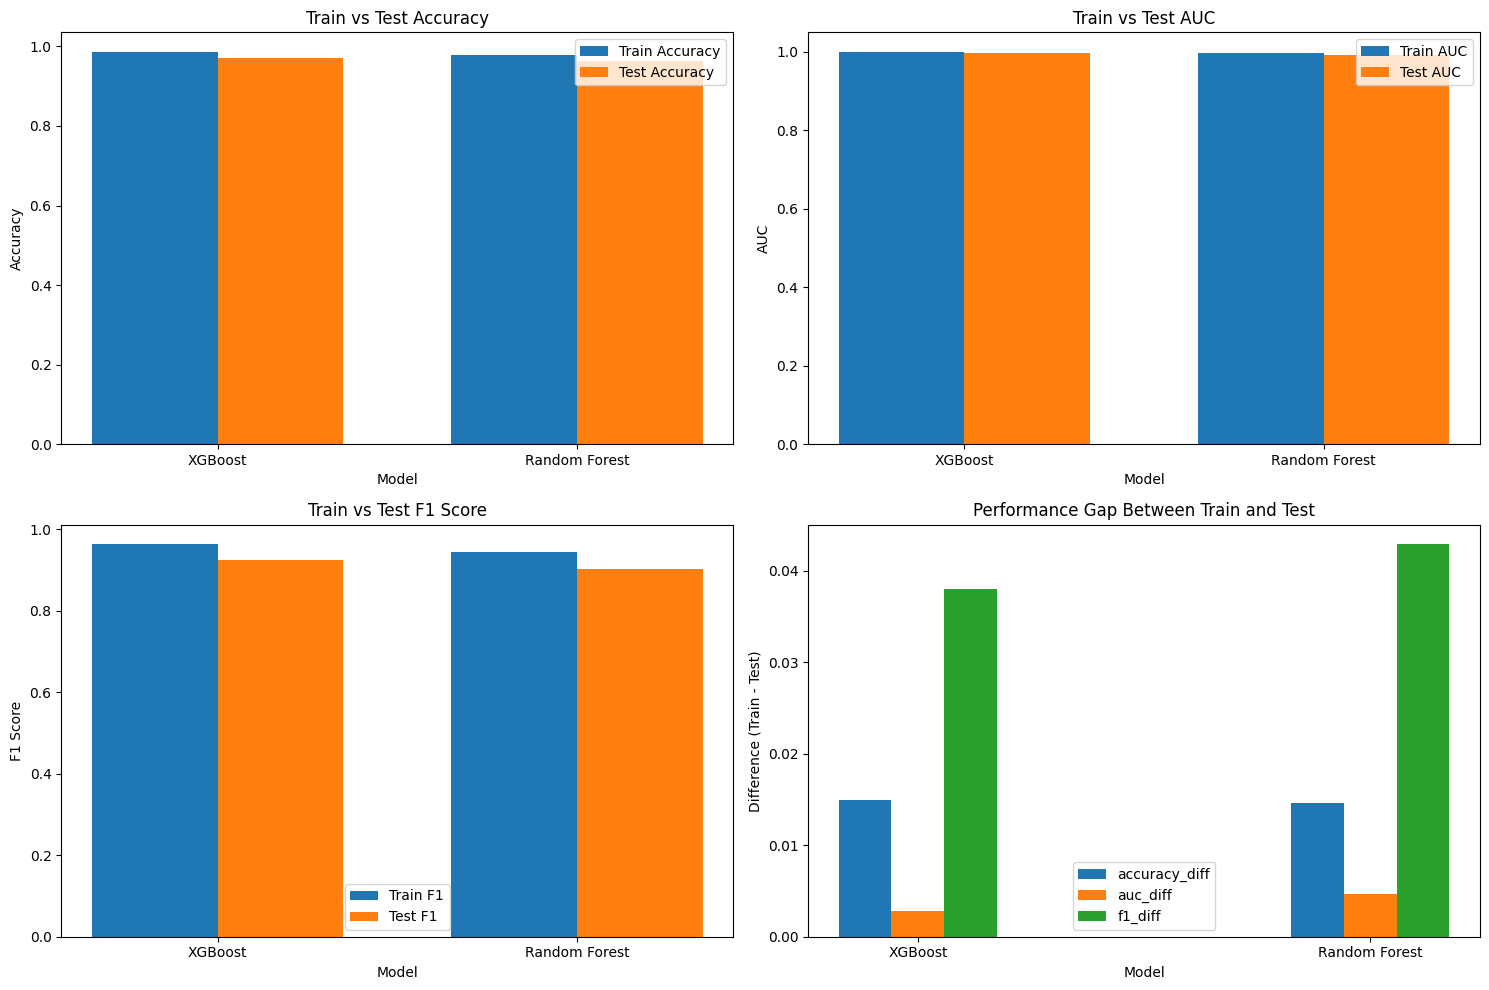


=== XGBoost Detailed Classification Report ===

Training Data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4861
           1       0.93      1.00      0.96      1087

    accuracy                           0.99      5948
   macro avg       0.96      0.99      0.98      5948
weighted avg       0.99      0.99      0.99      5948


Test Data:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1215
           1       0.88      0.98      0.93       272

    accuracy                           0.97      1487
   macro avg       0.94      0.97      0.95      1487
weighted avg       0.97      0.97      0.97      1487


=== Random Forest Detailed Classification Report ===

Training Data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4861
           1       0.90      0.99      0.95      1087

    accuracy                        

In [20]:
# ======================
# 11. COMPARATIVE EVALUATION (TRAIN vs TEST)
# ======================

# Fungsi untuk evaluasi model pada data train dan test
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Prediksi pada data training
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]

    # Prediksi pada data testing
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Metrik evaluasi
    train_accuracy = (y_train_pred == y_train).mean()
    test_accuracy = (y_test_pred == y_test).mean()
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Print hasil
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    # Hitung perbedaan performa
    accuracy_diff = train_accuracy - test_accuracy
    auc_diff = train_auc - test_auc
    f1_diff = train_f1 - test_f1

    print(f"\nPerformance Difference (Train - Test):")
    print(f"Accuracy Difference: {accuracy_diff:.4f}")
    print(f"AUC Difference: {auc_diff:.4f}")
    print(f"F1 Difference: {f1_diff:.4f}")

    # Analisis overfitting
    if accuracy_diff > 0.05 or auc_diff > 0.05:
        print("\n⚠️ Potential Overfitting Detected!")
        print("Model performs significantly better on training data than on test data.")
    elif train_accuracy < 0.7 or test_accuracy < 0.7:
        print("\n⚠️ Potential Underfitting Detected!")
        print("Model may not be capturing the underlying patterns effectively.")
    else:
        print("\n✅ Model appears to be well-fitted.")

    return {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'accuracy_diff': accuracy_diff,
        'auc_diff': auc_diff,
        'f1_diff': f1_diff
    }

# Evaluasi XGBoost
xgb_results = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, "XGBoost")

# Evaluasi Random Forest
rf_results = evaluate_model(calibrated_rf, X_train, y_train, X_test, y_test, "Random Forest")

# Visualisasi perbandingan performa
def plot_performance_comparison(results_list):
    # Buat dataframe untuk visualisasi
    df_results = pd.DataFrame(results_list)

    # Set figure size
    plt.figure(figsize=(15, 10))

    # Plot 1: Accuracy comparison
    plt.subplot(2, 2, 1)
    x = np.arange(len(df_results['model_name']))
    width = 0.35

    plt.bar(x - width/2, df_results['train_accuracy'], width, label='Train Accuracy')
    plt.bar(x + width/2, df_results['test_accuracy'], width, label='Test Accuracy')

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.xticks(x, df_results['model_name'])
    plt.legend()

    # Plot 2: AUC comparison
    plt.subplot(2, 2, 2)
    plt.bar(x - width/2, df_results['train_auc'], width, label='Train AUC')
    plt.bar(x + width/2, df_results['test_auc'], width, label='Test AUC')

    plt.xlabel('Model')
    plt.ylabel('AUC')
    plt.title('Train vs Test AUC')
    plt.xticks(x, df_results['model_name'])
    plt.legend()

    # Plot 3: F1 comparison
    plt.subplot(2, 2, 3)
    plt.bar(x - width/2, df_results['train_f1'], width, label='Train F1')
    plt.bar(x + width/2, df_results['test_f1'], width, label='Test F1')

    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('Train vs Test F1 Score')
    plt.xticks(x, df_results['model_name'])
    plt.legend()

    # Plot 4: Performance difference
    plt.subplot(2, 2, 4)
    diff_metrics = ['accuracy_diff', 'auc_diff', 'f1_diff']
    for i, metric in enumerate(diff_metrics):
        plt.bar(x + i*width/3, df_results[metric], width/3, label=metric)

    plt.xlabel('Model')
    plt.ylabel('Difference (Train - Test)')
    plt.title('Performance Gap Between Train and Test')
    plt.xticks(x + width/3, df_results['model_name'])
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualisasikan hasil perbandingan
plot_performance_comparison([xgb_results, rf_results])

# Classification report untuk data training dan testing
print("\n=== XGBoost Detailed Classification Report ===")
print("\nTraining Data:")
print(classification_report(y_train, xgb_model.predict(X_train)))
print("\nTest Data:")
print(classification_report(y_test, xgb_model.predict(X_test)))

print("\n=== Random Forest Detailed Classification Report ===")
print("\nTraining Data:")
print(classification_report(y_train, calibrated_rf.predict(X_train)))
print("\nTest Data:")
print(classification_report(y_test, calibrated_rf.predict(X_test)))

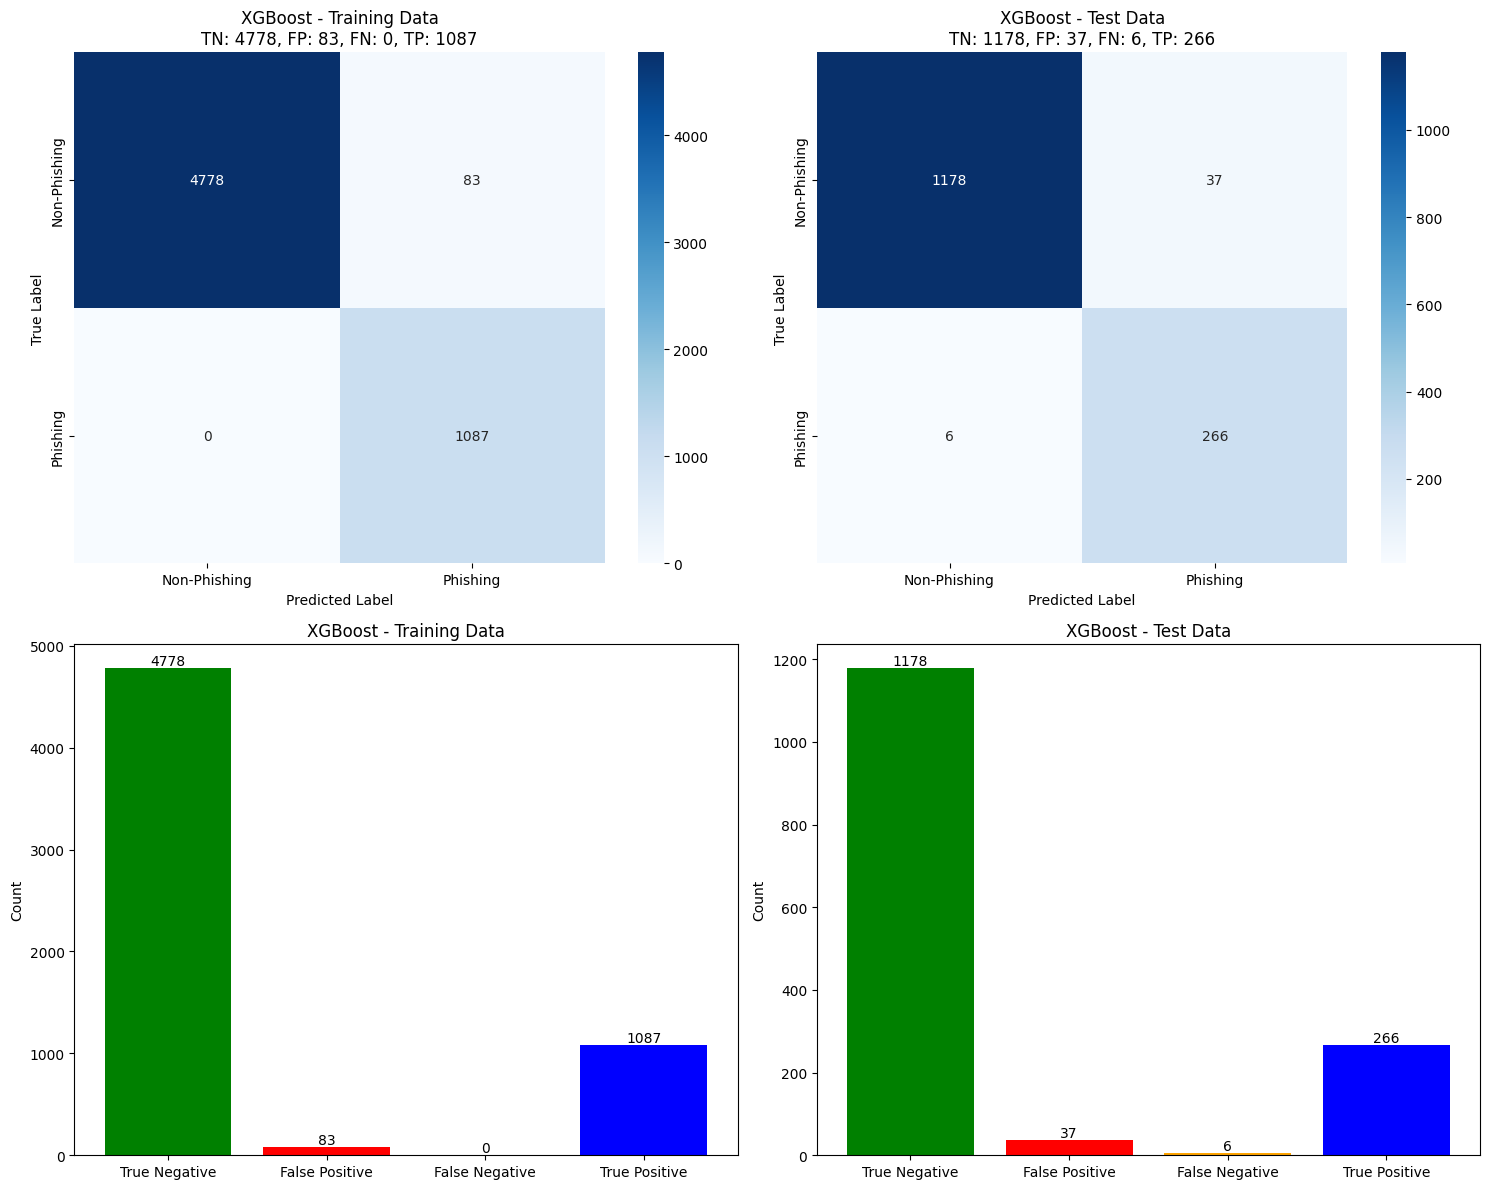


=== XGBoost Confusion Matrix Summary ===

Training Data:
True Negative (TN): 4778 - Correctly identified as non-phishing
False Positive (FP): 83 - Non-phishing incorrectly identified as phishing
False Negative (FN): 0 - Phishing incorrectly identified as non-phishing
True Positive (TP): 1087 - Correctly identified as phishing

False Positive Rate: 1.71%
False Negative Rate: 0.00%

Test Data:
True Negative (TN): 1178 - Correctly identified as non-phishing
False Positive (FP): 37 - Non-phishing incorrectly identified as phishing
False Negative (FN): 6 - Phishing incorrectly identified as non-phishing
True Positive (TP): 266 - Correctly identified as phishing

False Positive Rate: 3.05%
False Negative Rate: 2.21%

Comparison (Train vs Test):
FP Rate Change: 1.34%
FN Rate Change: 2.21%


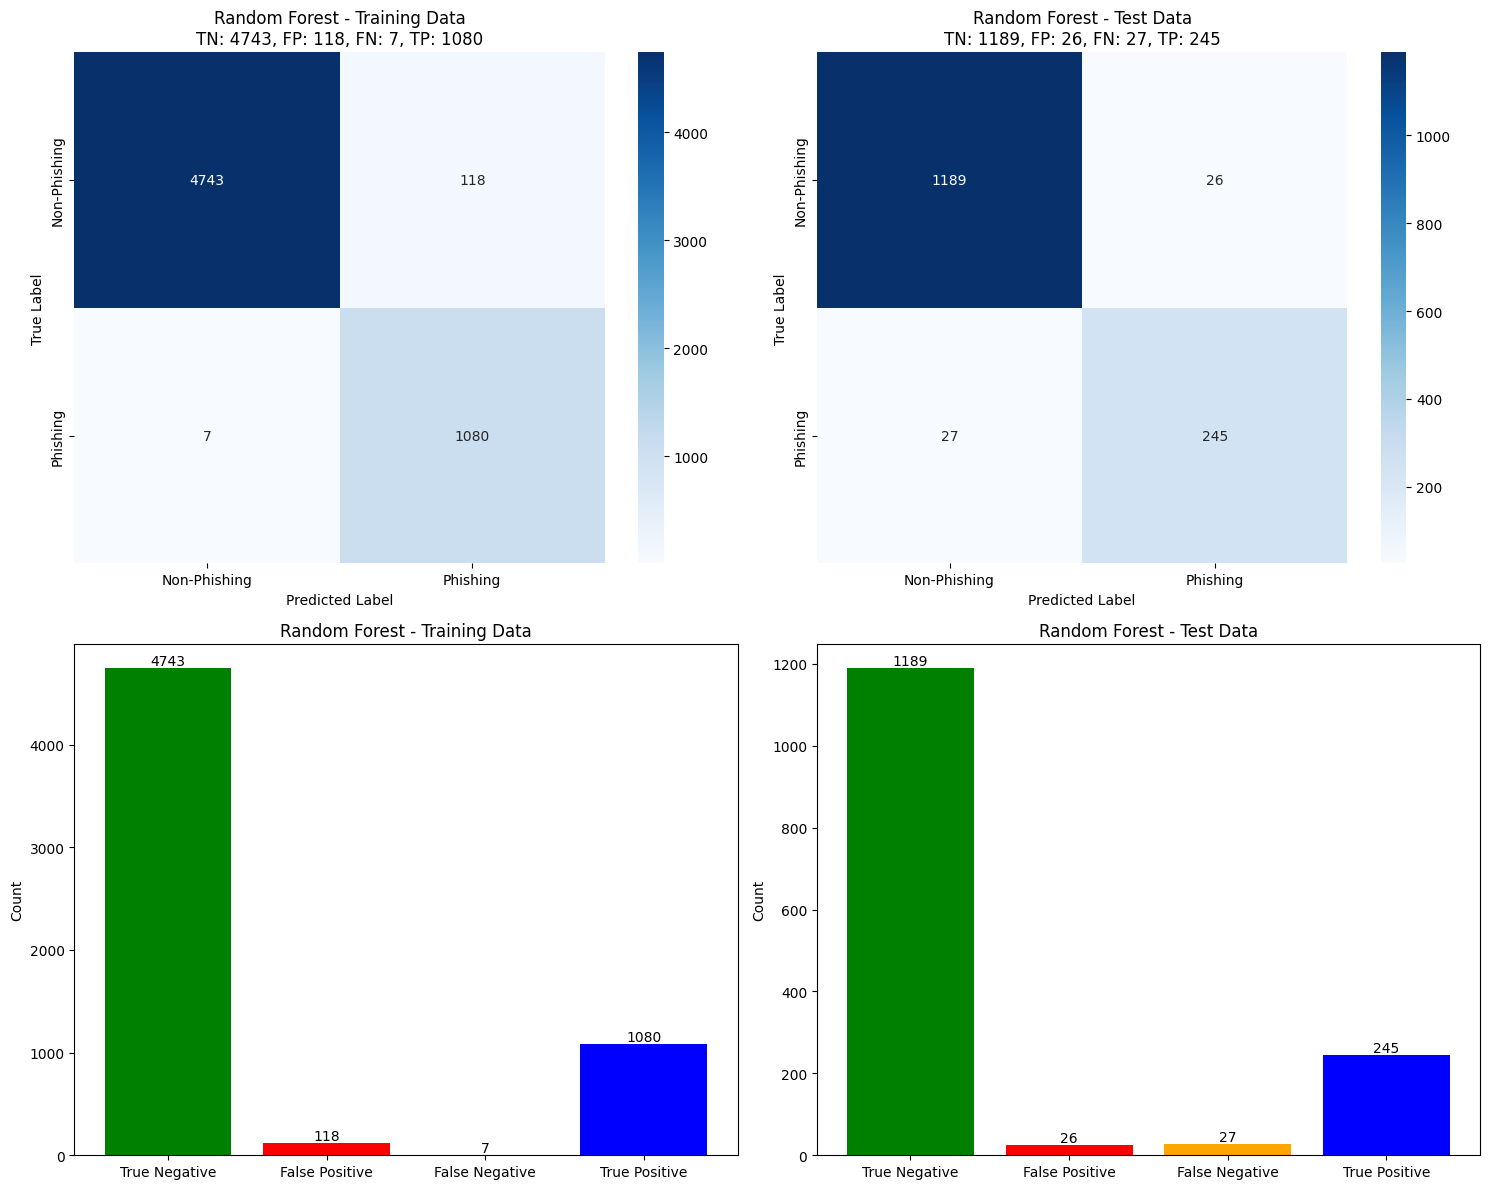


=== Random Forest Confusion Matrix Summary ===

Training Data:
True Negative (TN): 4743 - Correctly identified as non-phishing
False Positive (FP): 118 - Non-phishing incorrectly identified as phishing
False Negative (FN): 7 - Phishing incorrectly identified as non-phishing
True Positive (TP): 1080 - Correctly identified as phishing

False Positive Rate: 2.43%
False Negative Rate: 0.64%

Test Data:
True Negative (TN): 1189 - Correctly identified as non-phishing
False Positive (FP): 26 - Non-phishing incorrectly identified as phishing
False Negative (FN): 27 - Phishing incorrectly identified as non-phishing
True Positive (TP): 245 - Correctly identified as phishing

False Positive Rate: 2.14%
False Negative Rate: 9.93%

Comparison (Train vs Test):
FP Rate Change: -0.29%
FN Rate Change: 9.28%


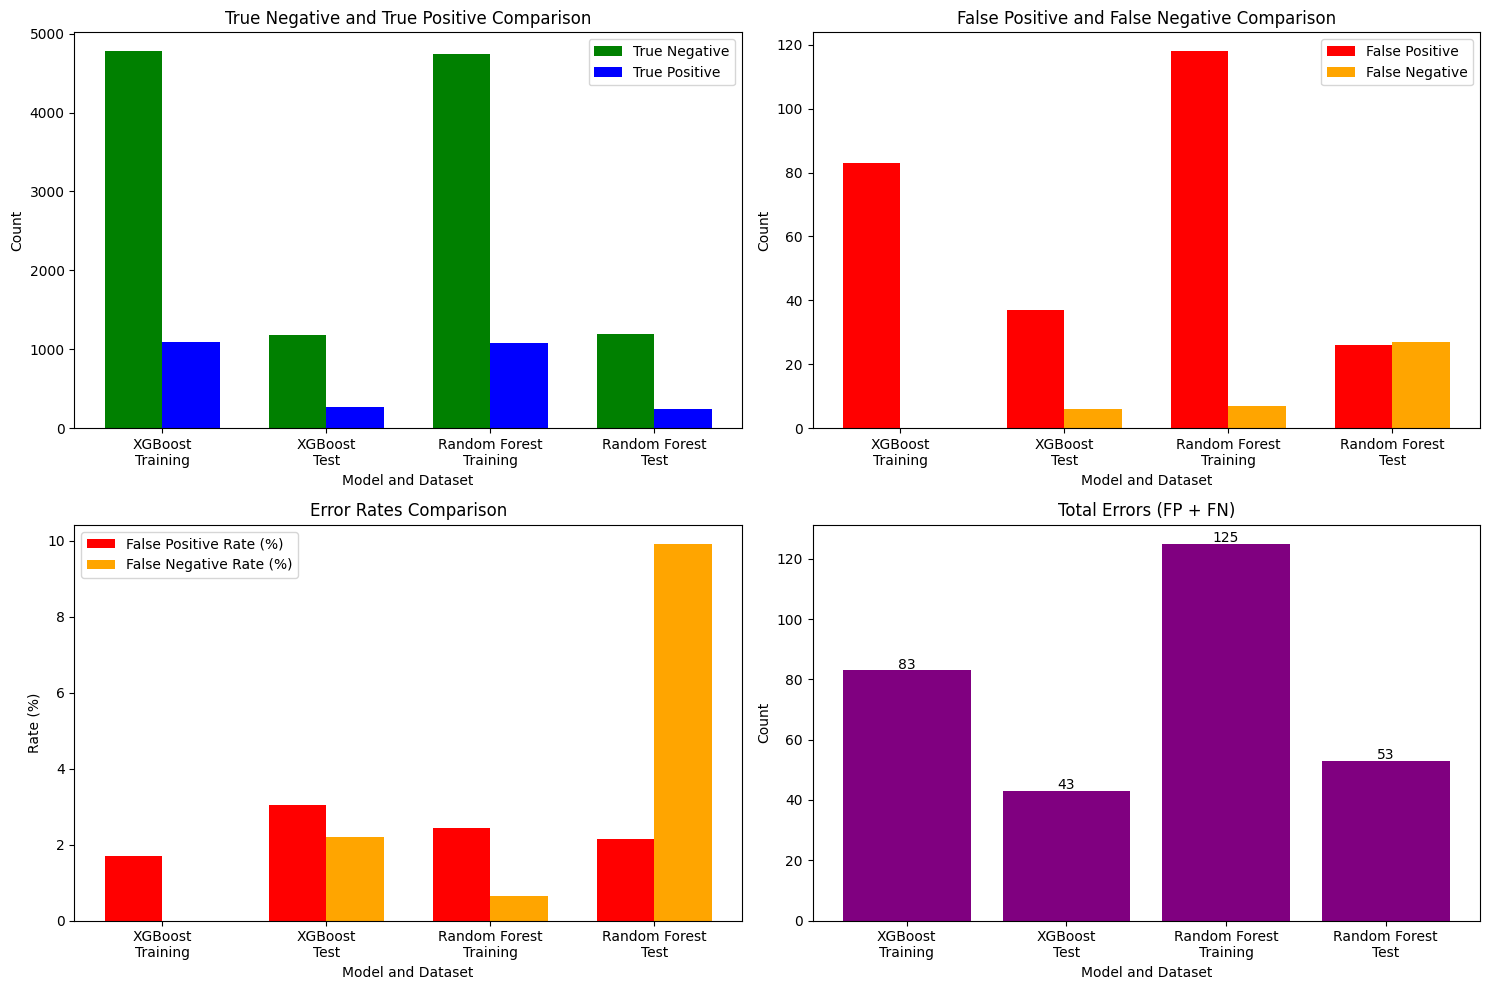

In [21]:
# ======================
# 13. CONFUSION MATRIX VISUALIZATION
# ======================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(model, X_train, y_train, X_test, y_test, model_name):
    # Prediksi untuk data training dan testing
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Hitung confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Ekstrak TP, TN, FP, FN untuk training
    tn_train, fp_train, fn_train, tp_train = cm_train.ravel()

    # Ekstrak TP, TN, FP, FN untuk testing
    tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

    # Buat figure dengan 2x2 subplot
    plt.figure(figsize=(15, 12))

    # Plot 1: Confusion Matrix untuk Training
    plt.subplot(2, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Phishing', 'Phishing'],
                yticklabels=['Non-Phishing', 'Phishing'])
    plt.title(f'{model_name} - Training Data\nTN: {tn_train}, FP: {fp_train}, FN: {fn_train}, TP: {tp_train}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Plot 2: Confusion Matrix untuk Testing
    plt.subplot(2, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Phishing', 'Phishing'],
                yticklabels=['Non-Phishing', 'Phishing'])
    plt.title(f'{model_name} - Test Data\nTN: {tn_test}, FP: {fp_test}, FN: {fn_test}, TP: {tp_test}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Plot 3: Bar Chart untuk Training
    plt.subplot(2, 2, 3)
    categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    values = [tn_train, fp_train, fn_train, tp_train]
    colors = ['green', 'red', 'orange', 'blue']

    bars = plt.bar(categories, values, color=colors)
    plt.title(f'{model_name} - Training Data')
    plt.ylabel('Count')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

    # Plot 4: Bar Chart untuk Testing
    plt.subplot(2, 2, 4)
    values = [tn_test, fp_test, fn_test, tp_test]

    bars = plt.bar(categories, values, color=colors)
    plt.title(f'{model_name} - Test Data')
    plt.ylabel('Count')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n=== {model_name} Confusion Matrix Summary ===")
    print(f"\nTraining Data:")
    print(f"True Negative (TN): {tn_train} - Correctly identified as non-phishing")
    print(f"False Positive (FP): {fp_train} - Non-phishing incorrectly identified as phishing")
    print(f"False Negative (FN): {fn_train} - Phishing incorrectly identified as non-phishing")
    print(f"True Positive (TP): {tp_train} - Correctly identified as phishing")

    # Calculate rates
    total_train = tn_train + fp_train + fn_train + tp_train
    fp_rate_train = fp_train / (fp_train + tn_train) * 100
    fn_rate_train = fn_train / (fn_train + tp_train) * 100

    print(f"\nFalse Positive Rate: {fp_rate_train:.2f}%")
    print(f"False Negative Rate: {fn_rate_train:.2f}%")

    print(f"\nTest Data:")
    print(f"True Negative (TN): {tn_test} - Correctly identified as non-phishing")
    print(f"False Positive (FP): {fp_test} - Non-phishing incorrectly identified as phishing")
    print(f"False Negative (FN): {fn_test} - Phishing incorrectly identified as non-phishing")
    print(f"True Positive (TP): {tp_test} - Correctly identified as phishing")

    # Calculate rates
    total_test = tn_test + fp_test + fn_test + tp_test
    fp_rate_test = fp_test / (fp_test + tn_test) * 100
    fn_rate_test = fn_test / (fn_test + tp_test) * 100

    print(f"\nFalse Positive Rate: {fp_rate_test:.2f}%")
    print(f"False Negative Rate: {fn_rate_test:.2f}%")

    # Compare train and test
    print(f"\nComparison (Train vs Test):")
    print(f"FP Rate Change: {fp_rate_test - fp_rate_train:.2f}%")
    print(f"FN Rate Change: {fn_rate_test - fn_rate_train:.2f}%")

    return {
        'model_name': model_name,
        'train': {'tn': tn_train, 'fp': fp_train, 'fn': fn_train, 'tp': tp_train},
        'test': {'tn': tn_test, 'fp': fp_test, 'fn': fn_test, 'tp': tp_test}
    }

# Visualisasi untuk XGBoost
xgb_cm_results = plot_confusion_matrices(xgb_model, X_train, y_train, X_test, y_test, "XGBoost")

# Visualisasi untuk Random Forest
rf_cm_results = plot_confusion_matrices(calibrated_rf, X_train, y_train, X_test, y_test, "Random Forest")

# ======================
# 14. COMPARATIVE VISUALIZATION
# ======================

def plot_model_comparison(cm_results_list):
    # Buat dataframe untuk visualisasi
    models = []
    datasets = []
    tn_values = []
    fp_values = []
    fn_values = []
    tp_values = []

    for result in cm_results_list:
        model_name = result['model_name']

        # Training data
        models.append(model_name)
        datasets.append('Training')
        tn_values.append(result['train']['tn'])
        fp_values.append(result['train']['fp'])
        fn_values.append(result['train']['fn'])
        tp_values.append(result['train']['tp'])

        # Test data
        models.append(model_name)
        datasets.append('Test')
        tn_values.append(result['test']['tn'])
        fp_values.append(result['test']['fp'])
        fn_values.append(result['test']['fn'])
        tp_values.append(result['test']['tp'])

    # Buat figure
    plt.figure(figsize=(15, 10))

    # Plot 1: TN and TP comparison
    plt.subplot(2, 2, 1)
    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, tn_values, width, label='True Negative', color='green')
    plt.bar(x + width/2, tp_values, width, label='True Positive', color='blue')

    plt.xlabel('Model and Dataset')
    plt.ylabel('Count')
    plt.title('True Negative and True Positive Comparison')
    plt.xticks(x, [f"{m}\n{d}" for m, d in zip(models, datasets)])
    plt.legend()

    # Plot 2: FP and FN comparison
    plt.subplot(2, 2, 2)
    plt.bar(x - width/2, fp_values, width, label='False Positive', color='red')
    plt.bar(x + width/2, fn_values, width, label='False Negative', color='orange')

    plt.xlabel('Model and Dataset')
    plt.ylabel('Count')
    plt.title('False Positive and False Negative Comparison')
    plt.xticks(x, [f"{m}\n{d}" for m, d in zip(models, datasets)])
    plt.legend()

    # Plot 3: Error rates comparison
    plt.subplot(2, 2, 3)

    # Calculate error rates
    fp_rates = [fp / (fp + tn) * 100 if (fp + tn) > 0 else 0 for fp, tn in zip(fp_values, tn_values)]
    fn_rates = [fn / (fn + tp) * 100 if (fn + tp) > 0 else 0 for fn, tp in zip(fn_values, tp_values)]

    plt.bar(x - width/2, fp_rates, width, label='False Positive Rate (%)', color='red')
    plt.bar(x + width/2, fn_rates, width, label='False Negative Rate (%)', color='orange')

    plt.xlabel('Model and Dataset')
    plt.ylabel('Rate (%)')
    plt.title('Error Rates Comparison')
    plt.xticks(x, [f"{m}\n{d}" for m, d in zip(models, datasets)])
    plt.legend()

    # Plot 4: Total errors comparison
    plt.subplot(2, 2, 4)
    total_errors = [fp + fn for fp, fn in zip(fp_values, fn_values)]

    plt.bar(x, total_errors, color='purple')
    plt.xlabel('Model and Dataset')
    plt.ylabel('Count')
    plt.title('Total Errors (FP + FN)')
    plt.xticks(x, [f"{m}\n{d}" for m, d in zip(models, datasets)])

    # Add value labels on bars
    for i, v in enumerate(total_errors):
        plt.text(i, v + 0.5, f'{v}', ha='center')

    plt.tight_layout()
    plt.show()

# Visualisasikan perbandingan antar model
plot_model_comparison([xgb_cm_results, rf_cm_results])

In [22]:
# === Kesimpulan Evaluasi Model Deteksi Phishing ===

# 1. Kedua model (XGBoost dan Random Forest) menunjukkan akurasi tinggi (>96%) pada data testing,
#    menandakan efektivitas dalam mendeteksi email phishing.

# 2. Tidak ada indikasi overfitting yang signifikan.
#    Perbedaan performa antara training dan testing masih dalam batas wajar.

# 3. XGBoost menunjukkan performa yang lebih stabil dan akurat dibandingkan Random Forest,
#    terutama dalam mendeteksi email phishing (FN Rate lebih rendah).

# 4. Random Forest mengalami penurunan signifikan pada FN Rate saat diuji (dari 0.64% ke 9.93%),
#    yang berisiko tinggi dalam konteks keamanan karena phishing bisa lolos deteksi.

# 5. XGBoost lebih unggul dalam generalisasi ke data baru:
#    - FP Rate Change: 1.34% vs -0.29%
#    - FN Rate Change: 2.21% vs 9.28%
#    Menunjukkan bahwa XGBoost lebih konsisten antara training dan testing.

# 6. Dalam deteksi phishing, False Negative lebih berbahaya daripada False Positive.
#    XGBoost memiliki FN Rate yang jauh lebih rendah (2.21% vs 9.93%),
#    menjadikannya pilihan yang lebih aman untuk aplikasi keamanan.

# 7. Kesimpulan: XGBoost direkomendasikan sebagai model deteksi phishing utama
#    karena performa yang lebih stabil, akurasi tinggi, dan risiko kesalahan yang lebih rendah.

In [23]:
# ======================
# 15. SAVE MODEL FOR DEPLOYMENT
# ======================

import joblib
import os
from datetime import datetime

# Buat direktori untuk menyimpan model
model_dir = 'phishing_detection_model'
os.makedirs(model_dir, exist_ok=True)

# Simpan model XGBoost (karena performanya sedikit lebih baik)
print("Saving XGBoost model...")
xgb_model_path = os.path.join(model_dir, 'xgboost_phishing_model.pkl')
joblib.dump(xgb_model, xgb_model_path)

# Simpan TF-IDF vectorizer
print("Saving TF-IDF vectorizer...")
tfidf_path = os.path.join(model_dir, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, tfidf_path)

# Simpan daftar fitur numerik yang digunakan
print("Saving feature list...")
numeric_features_path = os.path.join(model_dir, 'numeric_features.pkl')
joblib.dump(numeric_features, numeric_features_path)

# Simpan nama kolom target
target_col_path = os.path.join(model_dir, 'target_col.pkl')
joblib.dump(target_col, target_col_path)

# Simpan metadata model
model_metadata = {
    'model_type': 'XGBoost',
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'version': '1.0',
    'accuracy': 0.97,  # Berdasarkan hasil evaluasi
    'description': 'Phishing email detection model with comprehensive feature extraction'
}

metadata_path = os.path.join(model_dir, 'model_metadata.pkl')
joblib.dump(model_metadata, metadata_path)

print(f"\nModel and components saved to: {model_dir}/")
print("Files saved:")
for file in os.listdir(model_dir):
    print(f"- {file}")

Saving XGBoost model...
Saving TF-IDF vectorizer...
Saving feature list...

Model and components saved to: phishing_detection_model/
Files saved:
- model_metadata.pkl
- target_col.pkl
- numeric_features.pkl
- tfidf_vectorizer.pkl
- xgboost_phishing_model.pkl
